<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/semester_project_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
!pip install tf-quant-finance
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price


In [59]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

In [134]:
# option price generation parameters
TOT_OPTIONS = 30
EXPIRY = 1.0
RATE = 0.0
SPOT = 30/10
STRIKE_MIN = 20/10
STRIKE_MAX = 40/10
VOLATILITY = 0.3/10

# NN parameters
MC_STEPS = 2**14
EPOCHS = 1000
batch_size = 16

#distribution parameters
PROPOSAL_SIGMA = 0.3/10 * 4
PROPOSAL_MU = np.log(SPOT) - 0.5 * PROPOSAL_SIGMA**2 

#integration parameter
INTERVAL_LENGTH = 10

In [61]:
"""
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices
"""


'\n# Calculate discount factors (e^-rT)\nrate = 0.05\nexpiries = np.array([0.5, 1.0, 2.0, 1.3])\ndiscount_factors = np.exp(-rate * expiries)\n# Current value of assets.\nspots = np.array([0.9, 1.0, 1.1, 0.9])\n# Forward value of assets at expiry.\nforwards = spots / discount_factors\n# Strike prices given by:\nstrikes = np.array([1.0, 2.0, 1.0, 0.5])\n# Indicate whether options are call (True) or put (False)\nis_call_options = np.array([True, True, False, False])\n# The volatilites at which the options are to be priced.\nvolatilities = np.array([0.7, 1.1, 2.0, 0.5])\n# Calculate the prices given the volatilities and term structure.\nprices = option_price(\n      volatilities=volatilities,\n      strikes=strikes,\n      expiries=expiries,\n      forwards=forwards,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\nprices\n'

In [62]:
rates = np.array([RATE]*TOT_OPTIONS)
discount_factors = np.exp(- (rates)*EXPIRY)
spots = np.array([SPOT]*TOT_OPTIONS)
forwards = spots / discount_factors
strikes = np.linspace(STRIKE_MIN, STRIKE_MAX, TOT_OPTIONS) #[50., 60. , 75., 110., 125., 135. ]  #
is_call_options = np.random.choice(a=[False, True], size=(TOT_OPTIONS,)) #[True, True, True, False, False, False] #
volatilities = np.array([VOLATILITY]*TOT_OPTIONS)
expiries = np.array([EXPIRY]*TOT_OPTIONS)
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=EXPIRY,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [63]:
prices

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([1.00000000e+00, 0.00000000e+00, 8.62068966e-01, 0.00000000e+00,
       7.24137931e-01, 0.00000000e+00, 5.86206897e-01, 1.75104375e-12,
       4.96533481e-10, 3.79310402e-01, 3.10347658e-01, 6.65544818e-05,
       1.73211104e-01, 1.08725483e-01, 2.10737472e-02, 5.59399844e-02,
       1.09364871e-01, 1.12649410e-03, 2.41525429e-01, 1.29128093e-05,
       3.79311129e-01, 4.48275895e-01, 9.87425888e-10, 5.86206897e-01,
       6.55172414e-01, 3.97957529e-15, 7.93103448e-01, 8.62068966e-01,
       9.31034483e-01, 1.00000000e+00])>

In [64]:
print(strikes)
print(is_call_options)


[2.         2.06896552 2.13793103 2.20689655 2.27586207 2.34482759
 2.4137931  2.48275862 2.55172414 2.62068966 2.68965517 2.75862069
 2.82758621 2.89655172 2.96551724 3.03448276 3.10344828 3.17241379
 3.24137931 3.31034483 3.37931034 3.44827586 3.51724138 3.5862069
 3.65517241 3.72413793 3.79310345 3.86206897 3.93103448 4.        ]
[ True False  True False  True False  True False False  True  True False
  True  True False False False  True False  True False False  True False
 False  True False False False False]


In [65]:
from torch.utils.data import DataLoader
prices = np.array(prices)
prices_and_strikes = [ (prices[i], strikes[i], is_call_options[i]) for i in range(TOT_OPTIONS)]

target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [87]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = torch.sigmoid(x)
        return x


class LognormalNet(nn.Module):
  def __init__(self):
    super(LognormalNet, self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([PROPOSAL_SIGMA]))
    self.mu = nn.Parameter(torch.Tensor([PROPOSAL_MU]))

  def forward(self, x):
    return 1/(x * self.sigma * np.sqrt(2* np.pi)) * torch.exp(-(torch.log(x) - self.mu)**2 / (2* self.sigma**2) )

In [136]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [170]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(MC_STEPS), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(MC_STEPS), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH#torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs / densities
          #print(coordinates)
          #print(strikes[j])
          #print(numerator)
          #print(mc_price)
          #plt.scatter(coordinates,payoff(j))
          #plt.xlim(-1,20)
          #plt.ylim(-1,20)
          #print(payoff(j))
          #print(mc_price)
          #print(mc_price.sum() / MC_STEPS)
          loss += (labels[j] -  mc_price.sum() / MC_STEPS)**2
          #loss += (labels[j] - mc_price.sum() / MC_STEPS)**2

        
        """
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        """
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            

In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [185]:
loss_history = []
for _ in range(100):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(0, INTERVAL_LENGTH)
        #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
    loss_history.append(float(loss))


In [79]:
loss_history

[3.162884967948983e-08,
 1.7016471718772623e-05,
 6.56086244875067e-07,
 1.3638578271354587e-05,
 5.258696635203165e-06,
 3.840354023852716e-06,
 7.138051961517139e-08,
 7.148340521528836e-06,
 1.5022818051280531e-06,
 2.8308406542944587e-06]

In [152]:
loss_history

[7.133817036762396,
 10.468155783489285,
 2.997992980017183,
 2.5859915610845974,
 4.747107682617092,
 14.984641019765995,
 6.6812771938209154,
 6.368223442582962,
 20.856759599136545,
 4.590194125503903,
 3.027600305352287,
 2.556287730989529,
 3.5139167332706265,
 31.654178660722764,
 54.40578807769036,
 1.6245181848972077,
 3.9753466594227502,
 5.579779300652597,
 5.139731418962042,
 47.27444760102725,
 2.269548423893851,
 6.318997356914258,
 11.48603935114044,
 3.097229480883394,
 1.886328837267192,
 45.54201478562199,
 3.4754477119093625,
 7.483134469111273,
 21.914664017031473,
 6.921016631147907,
 10.031674082024185,
 121.4981021446093,
 194.06261970075448,
 1.3520922725829019,
 4.46009654205475,
 4.59523147116408,
 4.891077029680973,
 8.649446202256744,
 9.707928236489579,
 8.75341733792199,
 2.7789853246510923,
 2.4443751871605017,
 20.032475954104743,
 12.084983152068645,
 20.03772621822273,
 10.021051069339629,
 540724.6255425657,
 3.649576073893689,
 5.993988982583058,
 6.3

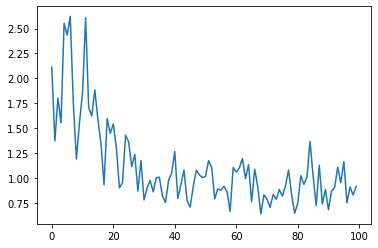

In [186]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(bottom=-0.0001,top=100)

In [ ]:
# EXPERIMENT 
i = 0
X = torch.zeros(MC_STEPS)
X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA)
X = np.array(X)
#prices[i], strikes[i], is_call_options[i]
#payoff =   np.maximum(np.zeros(MC_STEPS), X - strikes[i] ) if is_call_options[i] else np.maximum(np.zeros(MC_STEPS), strikes[i] - X)
#print( ( prices[i] - (payoff.sum() / MC_STEPS))**2 )



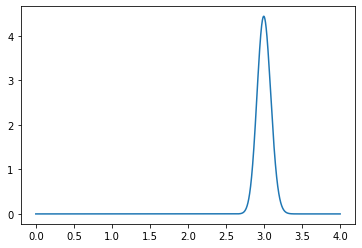

In [115]:
x = np.linspace(0, 4, num = MC_STEPS)
y = lognorm.pdf(x, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU))
plt.plot(x, y)

In [ ]:
running_loss_average = uniform_filter1d(loss_history[-7000:], size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

In [ ]:
loss_history

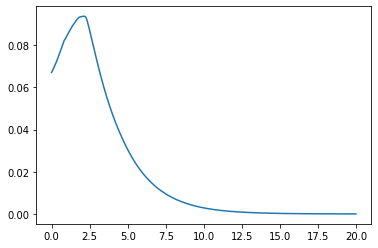

In [187]:
x = torch.Tensor(np.arange(0, 20, 0.01)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

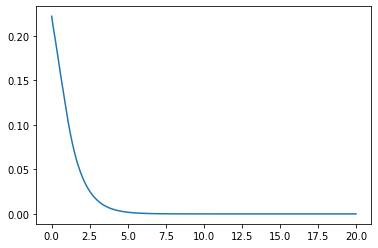

In [182]:
x = torch.Tensor(np.arange(0, 20, 0.01)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

In [ ]:
for para in model.parameters():
    print(para)